In [325]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

In [326]:
#import dataframe
df = pd.read_csv('KPI_AnalysisDataset2.csv')

In [ ]:
#Understand and Clean dataset

In [327]:
# Address Null Values : filling Defective_Units null values with zero to act as no reports of defective units
df['Defective_Units'] = df['Defective_Units'].fillna(0)

In [328]:
#change Date columns to pd.datetime and creating a Day column
df['Delivery_Date'] = pd.to_datetime(df['Delivery_Date'], format='%Y-%M-%d', errors='coerce')
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%Y-%M-%d', errors='coerce')
df['Day'] = df['Order_Date'].dt.day
df['Year'] = df['Order_Date'].dt.year

In [329]:
#update null values for Delivery Date with new column
def get_delivery_date(order_date):
    avg_delivery = pd.Timedelta(days=7)
    return order_date + avg_delivery
df['Delivery_Date'] = df.apply(lambda row: get_delivery_date(row['Order_Date']) if pd.isna(row['Delivery_Date']) else row['Delivery_Date'], axis=1)


In [330]:
# add Delivery time column
df['Delivery_Time'] = df['Delivery_Date'] - df['Order_Date']

In [331]:
# add column with Unit Price - Negotiated Price difference 
df['Price_Diff'] = df['Unit_Price'] - df['Negotiated_Price']

In [332]:
# add sales column
df['Total_Cost'] = df['Quantity'] * df['Negotiated_Price']

In [333]:
df = df.rename(columns={'Item_Category' : 'Category'})

In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   PO_ID             777 non-null    object         
 1   Supplier          777 non-null    object         
 2   Order_Date        777 non-null    datetime64[ns] 
 3   Delivery_Date     777 non-null    datetime64[ns] 
 4   Category          777 non-null    object         
 5   Order_Status      777 non-null    object         
 6   Quantity          777 non-null    int64          
 7   Unit_Price        777 non-null    float64        
 8   Negotiated_Price  777 non-null    float64        
 9   Defective_Units   777 non-null    float64        
 10  Compliance        777 non-null    object         
 11  Day               777 non-null    int32          
 12  Year              777 non-null    int32          
 13  Delivery_Time     777 non-null    timedelta64[ns]
 14  Price_Diff

In [407]:
df.describe()

,Order_Date,Delivery_Date,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Day,Year,Delivery_Time,Price_Diff,Total_Cost
count,777,777,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777,777.000000,777.000000
mean,2022-07-14 06:09:47.027026944,2022-07-21 16:25:10.193050368,1094.660232,58.283822,53.660721,61.710425,15.335907,2022.492921,7 days 10:15:23.166023166,4.623102,58396.005650
min,2022-01-01 00:01:00,2022-01-01 00:04:00,51.000000,10.840000,9.270000,0.000000,1.000000,2022.000000,-29 days +00:01:00,0.180000,772.800000
25%,2022-01-14 00:08:00,2022-01-18 00:02:00,615.000000,33.290000,30.460000,11.000000,8.000000,2022.000000,-11 days +00:01:00,1.900000,22221.850000
50%,2022-01-30 00:12:00,2022-02-04 00:04:00,1075.000000,58.950000,53.800000,38.000000,15.000000,2022.000000,6 days 00:00:00,3.650000,46776.360000
75%,2023-01-15 00:05:00,2023-01-17 00:12:00,1548.000000,83.130000,76.550000,85.000000,23.000000,2023.000000,11 days 00:00:00,6.640000,83088.710000
max,2024-01-01 00:01:00,2024-01-12 00:01:00,5000.000000,109.170000,107.390000,321.000000,31.000000,2024.000000,353 days 23:49:00,15.560000,432900.000000
std,NaN,NaN,647.844551,28.101315,26.094930,68.971194,8.593882,0.505398,46 days 06:37:14.087942491,3.455732,48236.432418


In [336]:
df.head()

,PO_ID,Supplier,Order_Date,Delivery_Date,Category,Order_Status,Quantity,Unit_Price,Negotiated_Price,Defective_Units,Compliance,Day,Year,Delivery_Time,Price_Diff,Total_Cost
0,PO-00001,Alpha_Inc,2023-01-17 00:10:00,2023-01-25 00:10:00,Office Supplies,Cancelled,1176,20.13,17.81,0.0,Yes,17,2023,8 days 00:00:00,2.32,20944.56
1,PO-00002,Delta_Logistics,2022-01-25 00:04:00,2022-01-05 00:05:00,Office Supplies,Delivered,1509,39.32,37.34,235.0,Yes,25,2022,-20 days +00:01:00,1.98,56346.06
2,PO-00003,Gamma_Co,2022-01-26 00:01:00,2022-01-15 00:02:00,MRO,Delivered,910,95.51,92.26,41.0,Yes,26,2022,-11 days +00:01:00,3.25,83956.60
3,PO-00004,Beta_Supplies,2022-01-09 00:10:00,2022-01-28 00:10:00,Packaging,Delivered,1344,99.85,95.52,112.0,Yes,9,2022,19 days 00:00:00,4.33,128378.88
4,PO-00005,Delta_Logistics,2022-01-08 00:09:00,2022-01-20 00:09:00,Raw Materials,Delivered,1180,64.07,60.53,171.0,No,8,2022,12 days 00:00:00,3.54,71425.40


In [337]:
# Begin EDA
# Null Hypothesis with a significance threshold of .05 a p-value less than the threshold is significant
# Alternative the p-value is greater than or equal to threshold .05 proving Null Hypothesis wrong therefore it is not significant
# Use  chi2 contingency to test hypothesis with multiple categorical variable and binary categorical variable
threshold = 0.05
def define_pval(p, threshold):
    if p < threshold:
        print("pval of {} is less than {} therefore it is Significant".format(p, threshold))
    else: 
        print("pval of {} is greater than or equal to {} so it is Not Significant".format(p, threshold))
comp_status = pd.crosstab(df.Order_Status, df.Compliance)
print(comp_status)

Compliance           No  Yes
Order_Status                
Cancelled            11   52
Delivered            96  464
Partially Delivered  17   56
Pending              13   68


In [338]:
chi2, pval, dof, expected = chi2_contingency(comp_status)
define_pval(pval, threshold)

pval of 0.6060467673380887 is greater than or equal to 0.05 so it is Not Significant


In [339]:
comp_supp = pd.crosstab(df.Supplier, df.Compliance)
print(comp_supp)

Compliance       No  Yes
Supplier                
Alpha_Inc         9  132
Beta_Supplies    38  118
Delta_Logistics  67  104
Epsilon_Group     3  163
Gamma_Co         20  123


In [340]:
chi2, pval, dof, expected = chi2_contingency(comp_supp)
define_pval(pval, threshold)

pval of 4.159522940130873e-21 is less than 0.05 therefore it is Significant


In [392]:
# See if there is inflation
df_22 = df[df['Year'] == 2022]
df_23 = df[df['Year'] == 2023]
m = np.mean(df_22.Unit_Price).round()
n = np.mean(df_23.Unit_Price).round()
u = (n/m)
print("The average Unit Price in 2022 was ${} and in 2023 rose ${} which is a $6 rise and %{} difference in Price.".format(m, n, u))

The average Unit Price in 2022 was $55.0 and in 2023 rose $61.0 which is a %1.1090909090909091 rise in Price.


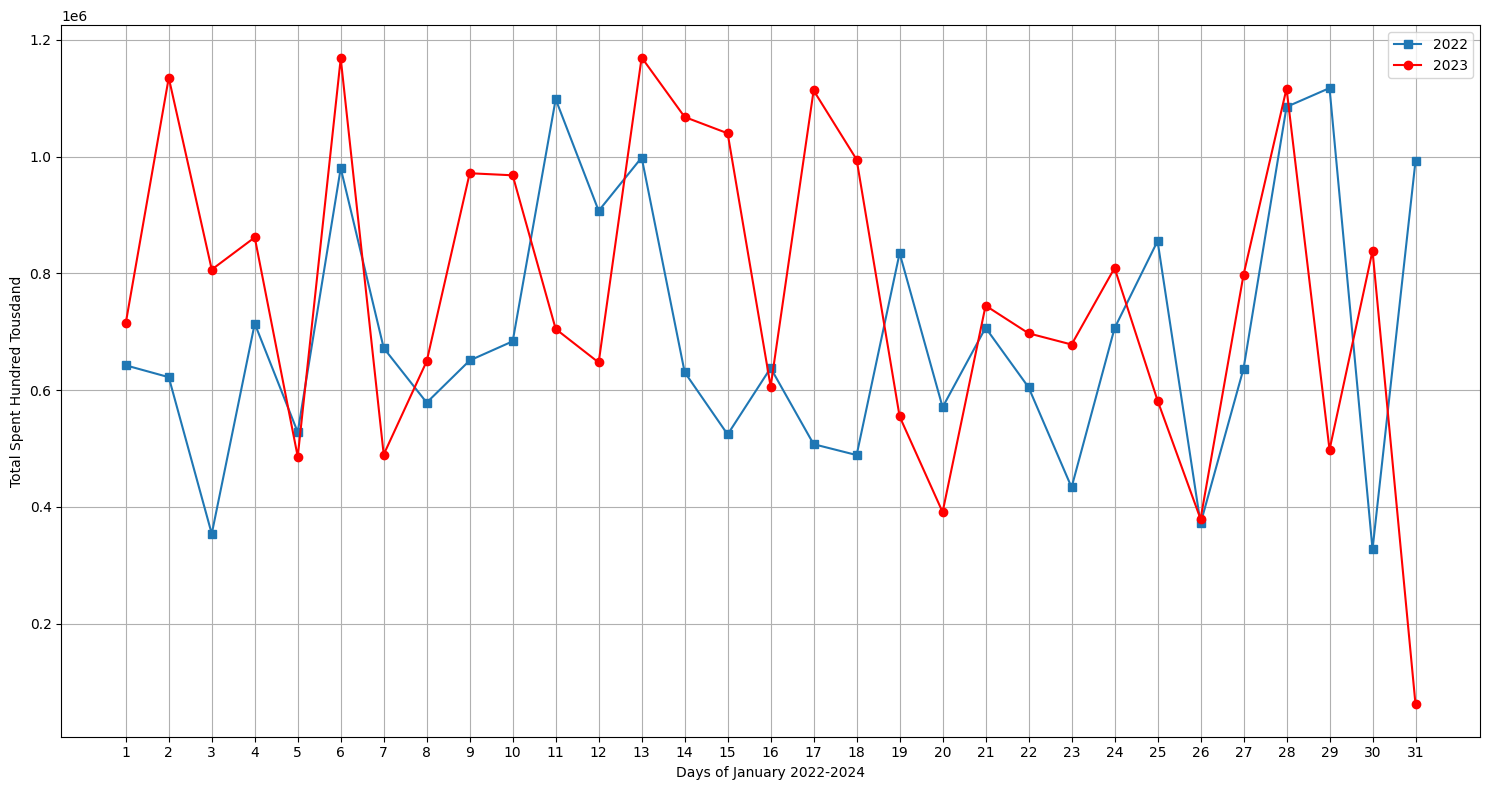

<Figure size 640x480 with 0 Axes>

In [395]:
#Showing Total Spent over the span of January, (which is the only month in the df), by day
temp = df_22.groupby('Day')['Total_Cost'].sum().reset_index()
l = df_23.groupby('Day')['Total_Cost'].sum().reset_index()
plt.figure(figsize=(15,8))
ax = plt.subplot()
plt.plot(temp.Day, temp.Total_Cost, marker='s',label='2022')
plt.plot(l.Day, l.Total_Cost, color='r', marker='o', label='2023')
plt.xlabel('Days of January 2022-2024')
plt.ylabel('Total Spent Hundred Tousdand')
x_ticks = temp.Day
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
plt.clf()

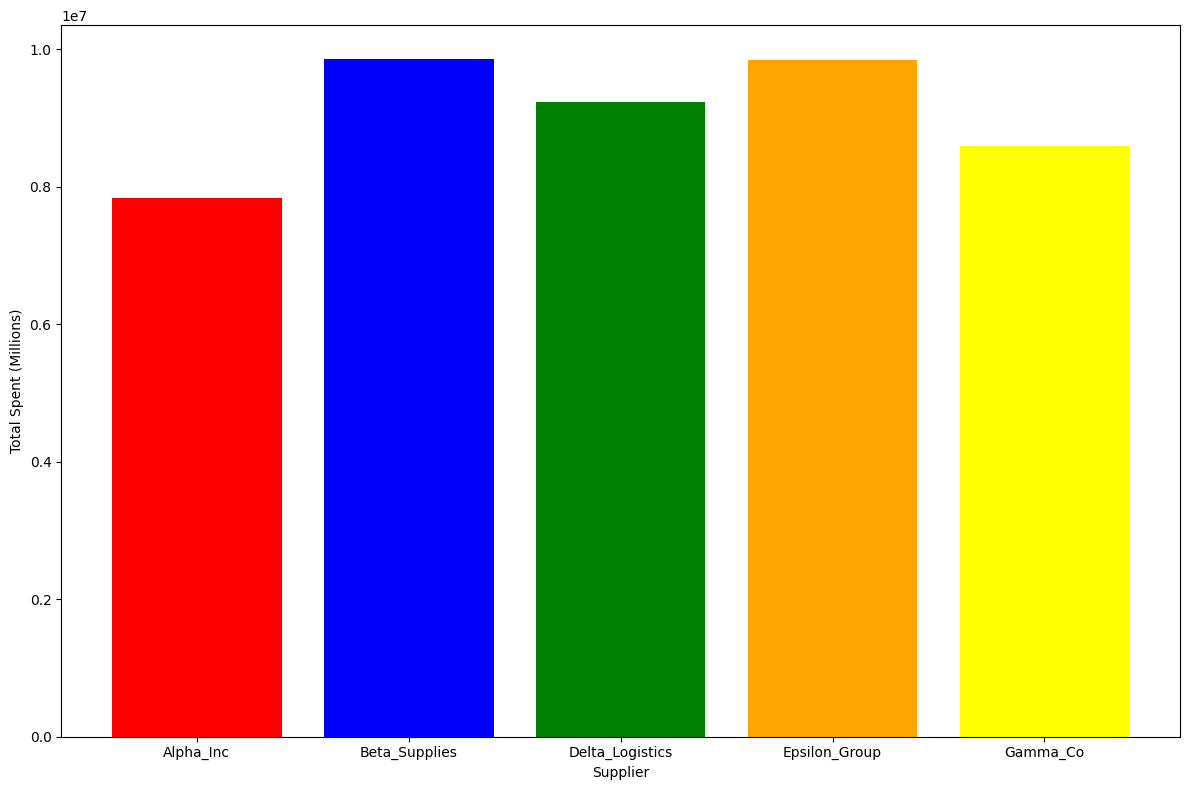

<Figure size 640x480 with 0 Axes>

In [343]:
# Showing which supplier we spend the most on 
temp2 = df.groupby('Supplier')['Total_Cost'].sum().reset_index()
plt.figure(figsize=(12,8))
plt.bar(temp2.Supplier, temp2.Total_Cost, color=('r','b','g', 'orange', 'yellow'))
plt.xlabel('Supplier')
plt.ylabel('Total Spent (Millions)')
plt.tight_layout()
plt.show()
plt.clf()

In [363]:
# Examine what we are spending the most money on
temp3 = df.groupby('Category')['Total_Cost'].sum().reset_index()
print(temp3.sort_values(by=['Total_Cost'], ascending=False))

          Category   Total_Cost
1              MRO  10126608.86
2  Office Supplies  10007583.03
0      Electronics   8642550.60
4    Raw Materials   8471241.42
3        Packaging   8125712.48


In [365]:
temp4 = df[df['Supplier'] == 'Beta_Supplies']
temp4 = temp4.groupby('Category')['Total_Cost'].sum().reset_index()
print(temp4.sort_values(by=['Total_Cost'], ascending=False))

          Category  Total_Cost
2  Office Supplies  2325498.00
4    Raw Materials  2285599.32
0      Electronics  2156144.46
1              MRO  1653533.59
3        Packaging  1437890.53


In [377]:
# Find out percents of order status
cancelled = df[df['Order_Status'] == 'Cancelled']
perc = (len(cancelled.PO_ID) / len(df.PO_ID)) * 100
delivered = df[df['Order_Status'] == 'Delivered']
per = (len(delivered.PO_ID)/len(df.PO_ID)) * 100
part = df[df['Order_Status'] == 'Partially Delivered']
p = (len(part.PO_ID)/len(df.PO_ID)) * 100
print("Orders cancelled: {}%". format(np.round(perc), 2))
print("Orders delivered: {}%".format(np.round(per), 2))
print("Orders partially delivered: {}%".format(np.round(p), 2))
print("Orders pending: 11.0%")

Orders cancelled: 8.0%
Orders delivered: 72.0%
Orders partially delivered: 9.0%
Orders pending: 11.0%


In [410]:
# Which supplier is being cancelled the most which supplier deleivers the most 
cancelled.Supplier.value_counts()

Supplier
Delta_Logistics    120
Epsilon_Group      120
Beta_Supplies      110
Alpha_Inc          107
Gamma_Co           103
Name: count, dtype: int64

In [411]:
# Which supplier delivers the most 
delivered.Supplier.value_counts()

Supplier
Delta_Logistics    120
Epsilon_Group      120
Beta_Supplies      110
Alpha_Inc          107
Gamma_Co           103
Name: count, dtype: int64

In [406]:
# Find the difference in 2022 cancelled and 2023 cancelled
o = df_22[df_22['Order_Status'] == 'Cancelled']
r = df_23[df_23['Order_Status'] == 'Cancelled']
prop22 = len(o.PO_ID)/len(df.PO_ID) * 100
prop23 = len(r.PO_ID)/len(df.PO_ID) * 100
diff = prop23 - prop22
print("Percent of Orders Cancelled in 2022: %{}, in 2023: %{}. Leading to a %{} rise in order cancellations".format(np.round(prop22, 2), np.round(prop23, 2), np.round(diff, 2))) 

Percent of Orders Cancelled in 2022: %3.35, in 2023: %4.76. Leading to a %1.42 rise in order cancellations


In [413]:
# Which supplier is responsible to the most defective units
supp = df.groupby('Supplier')['Defective_Units'].sum().reset_index()
print(supp.sort_values(by='Defective_Units', ascending=False))

          Supplier  Defective_Units
2  Delta_Logistics          19678.0
1    Beta_Supplies          13838.0
4         Gamma_Co           7034.0
3    Epsilon_Group           4682.0
0        Alpha_Inc           2717.0


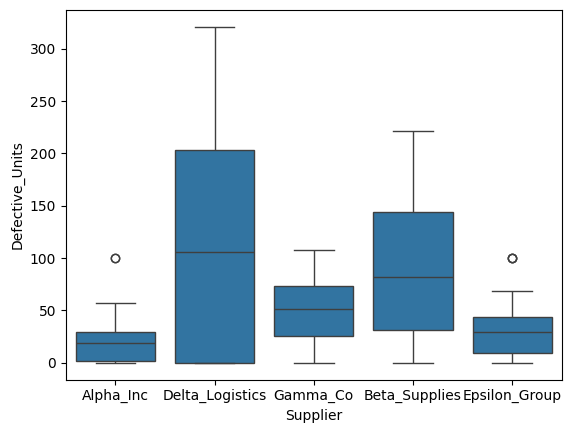

<Figure size 640x480 with 0 Axes>

In [414]:
# Explore Defective Units more 
sns.boxplot(x=df.Supplier, y=df.Defective_Units)
plt.show()
plt.clf()

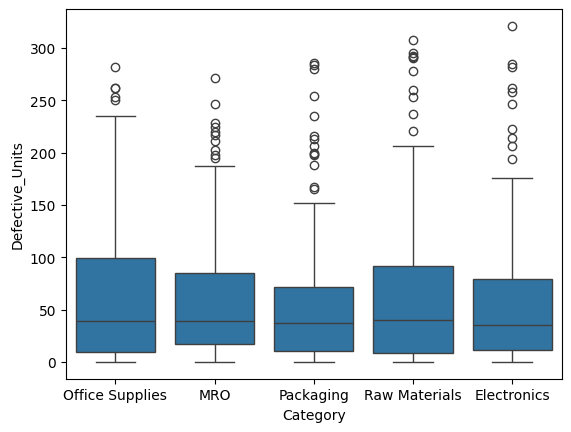

<Figure size 640x480 with 0 Axes>

In [415]:
sns.boxplot(x=df.Category, y=df.Defective_Units)
plt.show()
plt.clf()